In [1]:
import pandas as pd
import numpy as np
import re

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag
from collections import defaultdict
from nltk.corpus import wordnet as wn

import warnings
import keras
from keras import models
from keras.models import Sequential
from keras import layers
from keras.layers import Embedding, Bidirectional, Dense, LSTM, Conv1D, MaxPooling1D, Flatten, Reshape, TimeDistributed, Dropout
from keras import optimizers
from keras.callbacks import EarlyStopping
import tensorflow as tf
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from sklearn import metrics

Using TensorFlow backend.


## Read the Datasets

In [2]:
df=pd.read_json(r"./../../Dataset/Sarcasm_Headlines_Dataset_v2/Sarcasm_Headlines_Dataset_v2.json",lines=True)

In [3]:
df.shape

(28619, 3)

In [4]:
df.columns

Index(['is_sarcastic', 'headline', 'article_link'], dtype='object')

In [5]:
df['is_sarcastic'].value_counts()

0    14985
1    13634
Name: is_sarcastic, dtype: int64

In [6]:
#Check for any null values int he dataset
df.isnull().sum()

is_sarcastic    0
headline        0
article_link    0
dtype: int64

In [7]:
# Check for any duplicate rows

In [8]:
df['article_link'].nunique()

28617

In [9]:
#There are 2 duplicate rows
df.duplicated().sum()

2

In [10]:
#Remove duplicate rows
df.drop_duplicates(keep='first', inplace=True)

In [11]:
#No duplicated found
df.duplicated().sum()

0

## Data Cleaning

## Step 1:
### Remove Special Characters
### Check if numbers are required
### Remove anomalies like 1a 2b

In [12]:
%%time
df1=df.copy()

#Remove all single letter words
df1['headline']=df1['headline'].apply(lambda x: re.sub(r"[^\w\s]"," ",str(x)))

#Remove all numbers
df1['headline']=df1['headline'].apply(lambda x: re.sub(r'\d',"",str(x)))

#Remove extra spaces
df1['headline']=df1['headline'].apply(lambda x: " ".join(x.split()))

Wall time: 188 ms


## Step 2:
### Convert to lower case
### Remove Stopwords and special words that need to be removed
### Perform Lemmatization

In [13]:
%%time
stop=set(stopwords.words('english'))
#Update any words that we want to remove here
custom_list=['nan']
stop.update(custom_list)

tadDict = defaultdict(lambda : wn.NOUN)
tadDict['J'] = wn.ADJ
tadDict['V'] = wn.VERB
tadDict['R'] = wn.ADV

#Convert to lower case
df1['headline']=df1['headline'].apply(lambda x: x.lower())

#Remove stopwords
# df1['headline']=df1['headline'].apply(lambda x: " ".join([i for i in word_tokenize(x) if i.casefold() not in map(str.casefold,stop)]))

#Perform Lemmatization
df1['headline']=df1['headline'].apply(lambda x: " ".join(WordNetLemmatizer().lemmatize(word,tadDict[tag[0]]) for word,tag in pos_tag(word_tokenize(x))))

#Remove all single letter words
df1['headline']=df1['headline'].apply(lambda x: re.sub(r"( [a-z]{1} )|(^[a-z]{1} )|( [a-z]{1}$)"," ",str(x)))

#Remove extra spaces
df1['headline']=df1['headline'].apply(lambda x: " ".join(x.split()))

Wall time: 44.7 s


In [14]:
df_cleaned=df1.copy()

In [15]:
# Removing records that are having Null after cleaning.
df_cleaned=df_cleaned[df_cleaned['headline'].apply(lambda x: len(x)) > 0]

In [16]:
from collections import Counter
corpus=" ".join(df_cleaned['headline'])
corpus_split=corpus.split()
Counter=Counter(corpus_split)
most_occur = Counter.most_common(4)
most_occur

[('to', 9107), ('of', 6295), ('the', 5535), ('in', 4599)]

### Create Word Embeddings using Doc2Vec

In [17]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
# from sklearn import linear_model
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.svm import SVC
# from sklearn.neural_network import MLPClassifier
# from sklearn.linear_model import SGDClassifier
# from sklearn.ensemble import RandomForestClassifier, VotingClassifier
# from sklearn.metrics import precision_score, accuracy_score, recall_score
# from sklearn.decomposition import TruncatedSVD

import gensim
from gensim import corpora
from gensim import models
from gensim import similarities

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from multiprocessing import cpu_count

In [18]:
def read_corpus(df):
    for i in df['headline']:
        tokens=gensim.utils.simple_preprocess(i)
        yield TaggedDocument(tokens,i.split())
    
train_corpus=list(read_corpus(df))

In [19]:
%%time
model = Doc2Vec( vector_size=400, window=8, min_count=1, hs=1, epochs=10, workers=cpu_count())

model.build_vocab(train_corpus)
model.train(train_corpus,total_examples=model.corpus_count,epochs=model.epochs)

Wall time: 41.9 s


### Creating Sentence Vectors

In [20]:
def sentence_vector(sentence,model):
    sent_vec=[]
    for i in sentence:
        vector=model.infer_vector(i.split())
        sent_vec.append(vector)
    
    return pd.DataFrame(sent_vec)

In [21]:
headlines_vec=sentence_vector(df_cleaned['headline'],model)
min_max_scaler = preprocessing.MinMaxScaler()
headlines_vec = min_max_scaler.fit_transform(headlines_vec)
headlines_vec.shape

(28617, 400)

In [22]:
labels=df_cleaned['is_sarcastic']

## Creating Test Training Split

In [28]:
#training and test data splits
x_train, x_test, y_train, y_test = train_test_split(headlines_vec, labels, test_size = 0.2, random_state = 0)
x_train, x_val,  y_train, y_val  = train_test_split(x_train, y_train, test_size = 0.2, random_state = 0)

### Reshape the embeddings accordingly for input to LSTM

- Samples: One sequence is one sample. A batch is comprised of one or more samples.
- Time Steps: One time step is one point of observation in the sample.
- Features: One feature is one observation at a time step.

In [29]:
x_train=x_train.reshape(x_train.shape[0],1,x_train.shape[1])
x_val  =x_val.reshape(x_val.shape[0],1,x_val.shape[1])
x_test =x_test.reshape(x_test.shape[0],1,x_test.shape[1])

In [30]:
y_train=np.array(y_train).reshape(y_train.shape[0],1)
y_val  =np.array(y_val).reshape(y_val.shape[0],1)
y_test =np.array(y_test).reshape(y_test.shape[0],1)

In [31]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

(22921, 1, 400)
(22921, 1)
(2834, 1, 400)
(2834, 1)
(2862, 1, 400)
(2862, 1)


# Classification Task

## LSTM 32 nodes without Dropouts

In [32]:
# create the model
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.50, patience=2, verbose=1, mode='auto', cooldown=0, min_lr=0.00001)

early = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')

model = Sequential()
model.add(LSTM(32,input_shape=(x_train.shape[1],x_train.shape[2])))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
print(model.summary())

history  = model.fit(np.array(x_train), np.array(y_train),
 epochs= 30,
 batch_size = 100,
 validation_data = (np.array(x_val), np.array(y_val)),
 callbacks = [reduce_lr, early]
)

score = model.evaluate(x_test, y_test, verbose = 2)
print("score    : %.2f" % (score[0]*100))
print("Accuracy : %.2f%%" % (score[1]*100))
print("Precision: %.2f%%" % (score[2]*100))
print("Recall   : %.2f%%" % (score[3]*100))
print("F1-Score : %.2f%%" % ((2*(score[2]*score[3])/(score[2]+score[3]))*100))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 32)                55424     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 55,457
Trainable params: 55,457
Non-trainable params: 0
_________________________________________________________________
None
Train on 22921 samples, validate on 2834 samples
Epoch 1/30
22921/22921 [==============================] - 3s 144us/step - loss: 0.6637 - accuracy: 0.5904 - precision: 0.5434 - recall: 0.3521 - val_loss: 0.6467 - val_accuracy: 0.5843 - val_precision: 0.5980 - val_recall: 0.4323
Epoch 2/30
22921/22921 [==============================] - 2s 85us/step - loss: 0.6018 - accuracy: 0.6759 - precision: 0.6218 - recall: 0.4723 - val_loss: 0.5680 - val_accuracy: 0.7181 - val_precision: 0.6404 - val_recall: 0.5239

<AxesSubplot:>

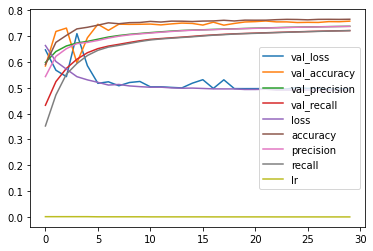

In [33]:
pd.DataFrame(history.history).plot(kind='line')

## LSTM 128 nodes without Dropouts

In [34]:
# create the model
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.50, patience=2, verbose=1, mode='auto', cooldown=0, min_lr=0.00001)

early = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')

model = Sequential()
model.add(LSTM(128,input_shape=(x_train.shape[1],x_train.shape[2])))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
print(model.summary())

history  = model.fit(np.array(x_train), np.array(y_train),
 epochs= 30,
 batch_size = 100,
 validation_data = (np.array(x_val), np.array(y_val)),
 callbacks = [reduce_lr, early]
)

score = model.evaluate(x_test, y_test, verbose = 2)
print("score    : %.2f" % (score[0]*100))
print("Accuracy : %.2f%%" % (score[1]*100))
print("Precision: %.2f%%" % (score[2]*100))
print("Recall   : %.2f%%" % (score[3]*100))
print("F1-Score : %.2f%%" % ((2*(score[2]*score[3])/(score[2]+score[3]))*100))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 128)               270848    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 270,977
Trainable params: 270,977
Non-trainable params: 0
_________________________________________________________________
None
Train on 22921 samples, validate on 2834 samples
Epoch 1/30
22921/22921 [==============================] - 3s 115us/step - loss: 0.6757 - accuracy: 0.5698 - precision_1: 0.5230 - recall_1: 0.3476 - val_loss: 0.6186 - val_accuracy: 0.6418 - val_precision_1: 0.5738 - val_recall_1: 0.4218
Epoch 2/30
22921/22921 [==============================] - 2s 89us/step - loss: 0.5979 - accuracy: 0.6737 - precision_1: 0.6047 - recall_1: 0.4698 - val_loss: 0.5516 - val_accuracy: 0.7230 - val_precision_1: 0.6312 - va

22921/22921 [==============================] - 2s 83us/step - loss: 0.4840 - accuracy: 0.7678 - precision_1: 0.7398 - recall_1: 0.7141 - val_loss: 0.4899 - val_accuracy: 0.7597 - val_precision_1: 0.7401 - val_recall_1: 0.7147
Epoch 00030: early stopping
score    : 49.76
Accuracy : 76.03%
Precision: 74.01%
Recall   : 71.49%
F1-Score : 72.73%


<AxesSubplot:>

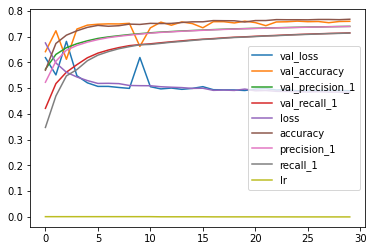

In [35]:
pd.DataFrame(history.history).plot(kind='line')

## LSTM 128 nodes with Dropouts

In [36]:
# create the model
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.50, patience=2, verbose=1, mode='auto', cooldown=0, min_lr=0.00001)

early = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')

model = Sequential()
model.add(LSTM(128,dropout=0.02,recurrent_dropout=0.02,input_shape=(x_train.shape[1],x_train.shape[2])))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
print(model.summary())

history  = model.fit(np.array(x_train), np.array(y_train),
 epochs= 30,
 batch_size = 100,
 validation_data = (np.array(x_val), np.array(y_val)),
 callbacks = [reduce_lr, early]
)

score = model.evaluate(x_test, y_test, verbose = 2)
print("score    : %.2f" % (score[0]*100))
print("Accuracy : %.2f%%" % (score[1]*100))
print("Precision: %.2f%%" % (score[2]*100))
print("Recall   : %.2f%%" % (score[3]*100))
print("F1-Score : %.2f%%" % ((2*(score[2]*score[3])/(score[2]+score[3]))*100))

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 128)               270848    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 270,977
Trainable params: 270,977
Non-trainable params: 0
_________________________________________________________________
None
Train on 22921 samples, validate on 2834 samples
Epoch 1/30
22921/22921 [==============================] - 3s 116us/step - loss: 0.6646 - accuracy: 0.5849 - precision_2: 0.5300 - recall_2: 0.3486 - val_loss: 0.7312 - val_accuracy: 0.4901 - val_precision_2: 0.5670 - val_recall_2: 0.4963
Epoch 2/30
22921/22921 [==============================] - 2s 84us/step - loss: 0.6061 - accuracy: 0.6667 - precision_2: 0.5863 - recall_2: 0.5528 - val_loss: 0.5812 - val_accuracy: 0.7022 - val_precision_2: 0.6065 - va

22921/22921 [==============================] - 2s 86us/step - loss: 0.5429 - accuracy: 0.7236 - precision_2: 0.7023 - recall_2: 0.6818 - val_loss: 0.5140 - val_accuracy: 0.7470 - val_precision_2: 0.7026 - val_recall_2: 0.6820
score    : 51.95
Accuracy : 75.23%
Precision: 70.27%
Recall   : 68.21%
F1-Score : 69.23%


<AxesSubplot:>

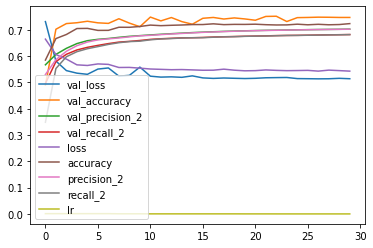

In [37]:
pd.DataFrame(history.history).plot(kind='line')

## Bi-Directional LSTM 128 nodes without Dropouts

In [38]:
# create the model
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.50, patience=2, verbose=1, mode='auto', cooldown=0, min_lr=0.00001)

early = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')

model = Sequential()
model.add(Bidirectional(LSTM(128),input_shape=(x_train.shape[1],x_train.shape[2])))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
print(model.summary())

history  = model.fit(np.array(x_train), np.array(y_train),
 epochs= 30,
 batch_size = 100,
 validation_data = (np.array(x_val), np.array(y_val)),
 callbacks = [reduce_lr, early]
)

score = model.evaluate(x_test, y_test, verbose = 2)
print("score    : %.2f" % (score[0]*100))
print("Accuracy : %.2f%%" % (score[1]*100))
print("Precision: %.2f%%" % (score[2]*100))
print("Recall   : %.2f%%" % (score[3]*100))
print("F1-Score : %.2f%%" % ((2*(score[2]*score[3])/(score[2]+score[3]))*100))

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 256)               541696    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 541,953
Trainable params: 541,953
Non-trainable params: 0
_________________________________________________________________
None
Train on 22921 samples, validate on 2834 samples
Epoch 1/30
22921/22921 [==============================] - 4s 172us/step - loss: 0.6708 - accuracy: 0.5797 - precision_3: 0.5286 - recall_3: 0.3376 - val_loss: 0.6113 - val_accuracy: 0.6955 - val_precision_3: 0.5894 - val_recall_3: 0.4400
Epoch 2/30
22921/22921 [==============================] - 3s 125us/step - loss: 0.6003 - accuracy: 0.6774 - precision_3: 0.6134 - recall_3: 0.5040 - val_loss: 0.6046 - val_accuracy: 0.6620 - val_precision_3: 0.6317 - v

<AxesSubplot:>

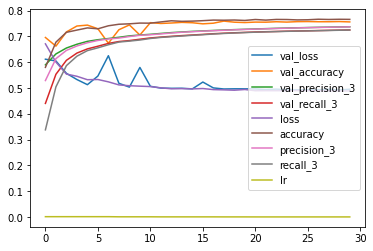

In [39]:
pd.DataFrame(history.history).plot(kind='line')